# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100
    
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [7]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


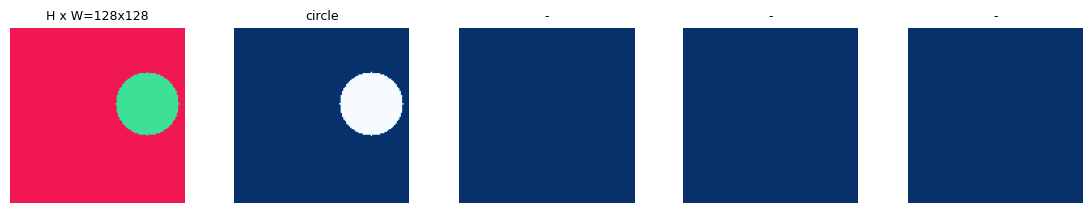

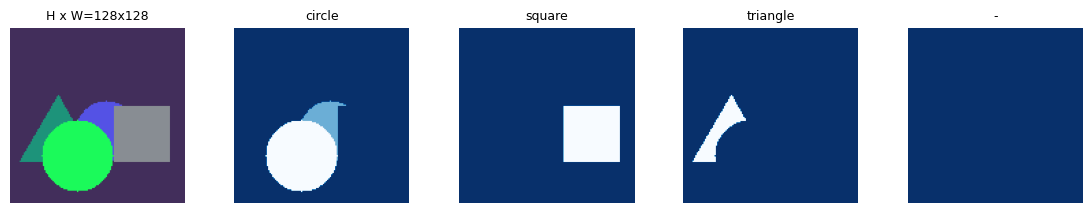

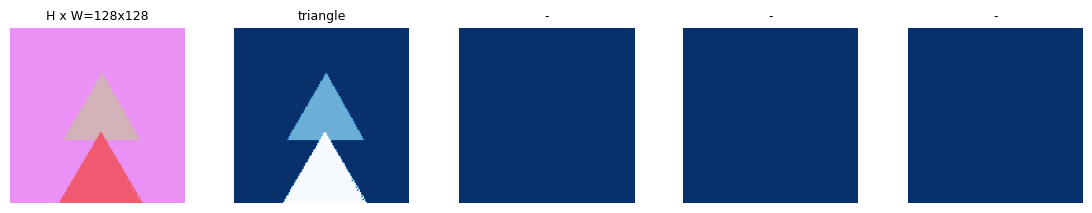

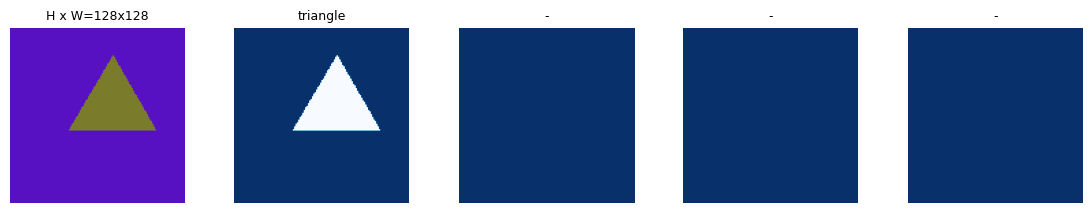

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

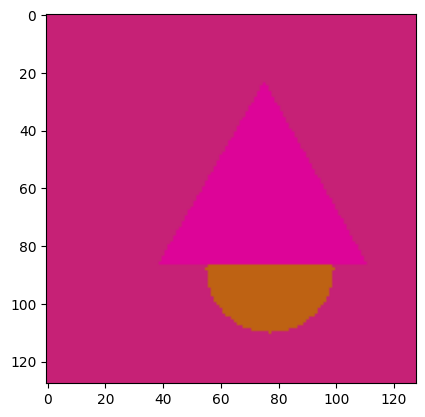

In [15]:
mage = dataset_train.load_image(4)
plt.imshow(mage)
plt.show()

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
box_ind is deprecated, use box_indices instead
[<tf.Tensor 'input_image:0' shape=(?, ?, ?, 3) dtype=float32>, <tf.Tensor 'input_image_meta:0' shape=(?, 16) dtype=float32>, <tf.Tensor 'input_rpn_match:0' shape=(?, ?, 1) dtype=int32>, <tf.Tensor 'input_rpn_bbox:0' shape=(?, ?, 4) dtype=float32>, <tf.Tensor 'input_gt_class_ids:0' shape=(?, ?) dtype=int32>, <tf.Tensor 'input_gt_boxes:0' shape=(?, ?, 4) dtype=float32>, <tf.Tensor 'input_gt_masks:0' shape=(?, 56, 56, ?) dtype=bool>]


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: c:\Users\steph\Documents\Programming\Python Projects\Mask_RCNN-master\logs\shapes20230118T1258\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrc

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

  1/100 [..............................] - ETA: 45:30 - loss: 8.7082

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

  2/100 [..............................] - ETA: 39:29 - loss: 7.4286

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

  3/100 [..............................] - ETA: 37:35 - loss: 6.5481

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

  4/100 [>.............................] - ETA: 36:25 - loss: 5.7869

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

  5/100 [>.............................] - ETA: 35:12 - loss: 5.4517

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

  6/100 [>.............................] - ETA: 34:08 - loss: 5.1012

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

  7/100 [=>............................] - ETA: 33:14 - loss: 4.7771

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

  8/100 [=>............................] - ETA: 32:32 - loss: 4.5253

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

  9/100 [=>............................] - ETA: 31:52 - loss: 4.3026

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 10/100 [==>...........................] - ETA: 31:16 - loss: 4.1309

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 11/100 [==>...........................] - ETA: 30:42 - loss: 3.9982

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 12/100 [==>...........................] - ETA: 30:08 - loss: 3.9050

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 13/100 [==>...........................] - ETA: 29:39 - loss: 3.8001

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 14/100 [===>..........................] - ETA: 29:09 - loss: 3.6898

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 15/100 [===>..........................] - ETA: 28:41 - loss: 3.5936

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 16/100 [===>..........................] - ETA: 28:15 - loss: 3.5012

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 17/100 [====>.........................] - ETA: 27:50 - loss: 3.4653

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 18/100 [====>.........................] - ETA: 27:24 - loss: 3.3864

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 19/100 [====>.........................] - ETA: 26:59 - loss: 3.3097

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 20/100 [=====>........................] - ETA: 26:36 - loss: 3.2309

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 21/100 [=====>........................] - ETA: 26:13 - loss: 3.1637

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 22/100 [=====>........................] - ETA: 25:50 - loss: 3.1047

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 23/100 [=====>........................] - ETA: 25:27 - loss: 3.0454

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 24/100 [======>.......................] - ETA: 25:05 - loss: 2.9887

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 25/100 [======>.......................] - ETA: 24:43 - loss: 2.9278

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 26/100 [======>.......................] - ETA: 24:22 - loss: 2.8794

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 27/100 [=======>......................] - ETA: 24:01 - loss: 2.8295

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 28/100 [=======>......................] - ETA: 23:41 - loss: 2.7854

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 29/100 [=======>......................] - ETA: 23:22 - loss: 2.7468

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 30/100 [========>.....................] - ETA: 23:02 - loss: 2.7046

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 31/100 [========>.....................] - ETA: 22:41 - loss: 2.6630

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 32/100 [========>.....................] - ETA: 22:21 - loss: 2.6247

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 33/100 [========>.....................] - ETA: 22:00 - loss: 2.5900

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 34/100 [=========>....................] - ETA: 21:40 - loss: 2.5600

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 35/100 [=========>....................] - ETA: 21:19 - loss: 2.5286

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 36/100 [=========>....................] - ETA: 21:00 - loss: 2.4987

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 37/100 [==========>...................] - ETA: 20:40 - loss: 2.4654

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 38/100 [==========>...................] - ETA: 20:20 - loss: 2.4348

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 39/100 [==========>...................] - ETA: 20:00 - loss: 2.4124

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 40/100 [===========>..................] - ETA: 19:40 - loss: 2.3899

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 41/100 [===========>..................] - ETA: 19:20 - loss: 2.3742

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 42/100 [===========>..................] - ETA: 19:00 - loss: 2.3509

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 43/100 [===========>..................] - ETA: 18:40 - loss: 2.3258

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 44/100 [============>.................] - ETA: 18:19 - loss: 2.3007

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 45/100 [============>.................] - ETA: 17:59 - loss: 2.2781

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 46/100 [============>.................] - ETA: 17:39 - loss: 2.2599

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 47/100 [=============>................] - ETA: 17:19 - loss: 2.2372

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 48/100 [=============>................] - ETA: 16:59 - loss: 2.2163

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 49/100 [=============>................] - ETA: 16:39 - loss: 2.1933

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 50/100 [==============>...............] - ETA: 16:19 - loss: 2.1790

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 51/100 [==============>...............] - ETA: 15:59 - loss: 2.1591

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 52/100 [==============>...............] - ETA: 15:39 - loss: 2.1345

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 53/100 [==============>...............] - ETA: 15:19 - loss: 2.1130

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 54/100 [===============>..............] - ETA: 14:59 - loss: 2.0960

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 55/100 [===============>..............] - ETA: 14:39 - loss: 2.0731

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 56/100 [===============>..............] - ETA: 14:19 - loss: 2.0596

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 57/100 [================>.............] - ETA: 14:00 - loss: 2.0414

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 58/100 [================>.............] - ETA: 13:40 - loss: 2.0252

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 59/100 [================>.............] - ETA: 13:20 - loss: 2.0110

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 60/100 [=================>............] - ETA: 13:00 - loss: 1.9958

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 61/100 [=================>............] - ETA: 12:41 - loss: 1.9795

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 62/100 [=================>............] - ETA: 12:21 - loss: 1.9644

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 63/100 [=================>............] - ETA: 12:01 - loss: 1.9470

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 64/100 [==================>...........] - ETA: 11:41 - loss: 1.9343

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 65/100 [==================>...........] - ETA: 11:22 - loss: 1.9217

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 66/100 [==================>...........] - ETA: 11:02 - loss: 1.9064

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 67/100 [===================>..........] - ETA: 10:42 - loss: 1.8928

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 68/100 [===================>..........] - ETA: 10:23 - loss: 1.8779

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 69/100 [===================>..........] - ETA: 10:03 - loss: 1.8663

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 70/100 [====================>.........] - ETA: 9:43 - loss: 1.8518 

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 71/100 [====================>.........] - ETA: 9:24 - loss: 1.8387

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 72/100 [====================>.........] - ETA: 9:04 - loss: 1.8260

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 73/100 [====================>.........] - ETA: 8:45 - loss: 1.8171

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 74/100 [=====================>........] - ETA: 8:25 - loss: 1.8053

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 75/100 [=====================>........] - ETA: 8:06 - loss: 1.7943

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 76/100 [=====================>........] - ETA: 7:46 - loss: 1.7826

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 77/100 [======================>.......] - ETA: 7:27 - loss: 1.7731

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 78/100 [======================>.......] - ETA: 7:07 - loss: 1.7607

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 79/100 [======================>.......] - ETA: 6:48 - loss: 1.7530

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 80/100 [=======================>......] - ETA: 6:28 - loss: 1.7458

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 81/100 [=======================>......] - ETA: 6:09 - loss: 1.7349

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 82/100 [=======================>......] - ETA: 5:49 - loss: 1.7266

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 83/100 [=======================>......] - ETA: 5:30 - loss: 1.7175

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 84/100 [========================>.....] - ETA: 5:10 - loss: 1.7087

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 85/100 [========================>.....] - ETA: 4:51 - loss: 1.6982

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 86/100 [========================>.....] - ETA: 4:31 - loss: 1.6868

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 87/100 [=========================>....] - ETA: 4:12 - loss: 1.6762

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 88/100 [=========================>....] - ETA: 3:52 - loss: 1.6666

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 89/100 [=========================>....] - ETA: 3:33 - loss: 1.6558

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 90/100 [==========================>...] - ETA: 3:14 - loss: 1.6464

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 91/100 [==========================>...] - ETA: 2:55 - loss: 1.6372

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 92/100 [==========================>...] - ETA: 2:35 - loss: 1.6291

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 93/100 [==========================>...] - ETA: 2:16 - loss: 1.6214

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 94/100 [===========================>..] - ETA: 1:56 - loss: 1.6136

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 95/100 [===========================>..] - ETA: 1:37 - loss: 1.6056

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 96/100 [===========================>..] - ETA: 1:17 - loss: 1.5988

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 97/100 [============================>.] - ETA: 58s - loss: 1.5927 

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 98/100 [============================>.] - ETA: 39s - loss: 1.5835

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

 99/100 [============================>.] - ETA: 19s - loss: 1.5757

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

  1/100 [..............................] - ETA: 6:42 - loss: 0.9880

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

  2/100 [..............................] - ETA: 4:30 - loss: 0.9335

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

  3/100 [..............................] - ETA: 3:46 - loss: 0.8965

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

  4/100 [>.............................] - ETA: 3:23 - loss: 0.8859

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

100/100 [==============================] - 2030s 20s/step - loss: 1.5688 - val_loss: 0.8522


In [11]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: c:\Users\steph\Documents\Programming\Python Projects\Mask_RCNN-master\logs\shapes20230118T1258\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (Batc

c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\steph\Environments\mask-rcnn-gpu\lib\site-packages\ipykernel_launcher.py:66: Depr

ValueError: Tensor conversion requested dtype float32_ref for Tensor with dtype float32: <tf.Tensor 'training_2/SGD/anchors/Variable/momentum/Initializer/zeros:0' shape=(8, 4092, 4) dtype=float32>

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_heads.h5")
print(model_path)
model.keras_model.save_weights(model_path)

c:\Users\steph\Documents\Programming\Python Projects\Mask_RCNN-master\logs\mask_rcnn_shapes_heads.h5


## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))